<a href="https://colab.research.google.com/github/bforoura/GENAI26/blob/main/Module2/chapter2_example4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Building a Complex Router Chain**

* One common use case for **router chains** is when we have multiple prompts, each specialized for a particular type of input or task.

* We need to define specialized prompts and then dynamically route inputs to the appropriate prompt based on the input content.

* We can also define a default chain, which will be used for inputs that don't match any of the specialized prompts.

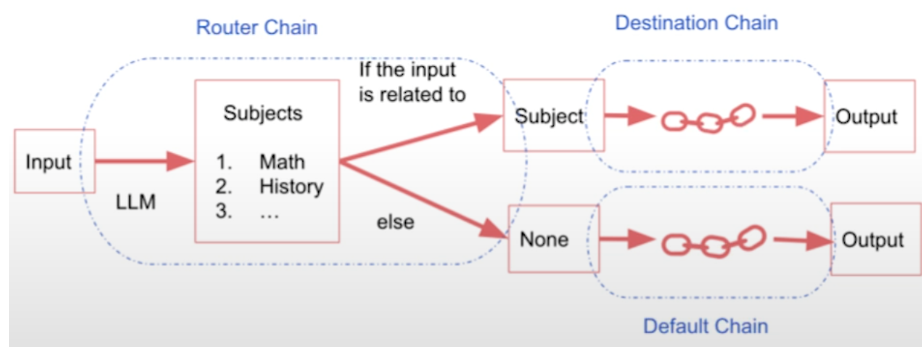

# **Benefits of Modular Specialization**


---
1. **Increased Prompt Precision (Context Window Efficiency)**
   * Generic prompts often suffer from "instruction bloat."
   * If you try to tell a single model how to be a mathematician, a historian, and a creative writer all at once, the prompt becomes long and confusing.

    * **Without Routing**: You send a massive prompt containing rules for 10 different subjects.

    * **With Routing**: The math_chain only contains instructions relevant to math. This reduces **"noise"** and helps the model follow specific formatting or logic requirements more accurately.

---
2. **Specialized System Instructions**

    * Different tasks require different **"personalities"** or logical frameworks.
    
    * **The Math Chain**: Might be instructed to "think step-by-step" or output results in LaTeX.

    * **The History Chain**: Might be instructed to "cite primary sources" or "provide a timeline." By routing, we ensure the model adopts the exact mental framework needed for the specific problem.

---
3. **Model Optimization and Cost Control**

   * Not every task requires a "heavyweight" model. Routing allows us to assign different models to different tasks:

   * **Routing Logic**: Use a tiny, cheap model (like Gemini Flash) to classify the intent.

   * **Hard Math**: Route the input to a powerful model (like Gemini Pro).

---
4. **Cleaner Output Parsing**

    * Specialized chains allow for specialized output parsers.
    * If the **math_chain** is routed to a function that needs to calculate a value, you can use a JsonOutputParser to ensure you get a clean integer.
    * If the **history_chain** is routed, you might want a StrOutputParser for a long-form essay.

---
5. **Debugging and Observability**
  * When a system fails, routing makes it obvious where the break occurred.
  

In [2]:
# Install the needed libraries

!pip install -q -U langchain langchain-core langchain-google-genai

# **How the Chain Flows**


* The logic follows a **"Map-Reduce" **style flow where the input is branched based on the model's own classification.

* The **router_chain** acts as a gatekeeper, condensing the user's intent into a single keyword.

* The **dictionary** {"topic": router_chain, "input": RunnablePassthrough()} ensures that while the router is working, the original user query is preserved in the "input" key for later use.

* The **RunnableLambda** acts as a switchboard, directing the preserved input to the correct destination chain.

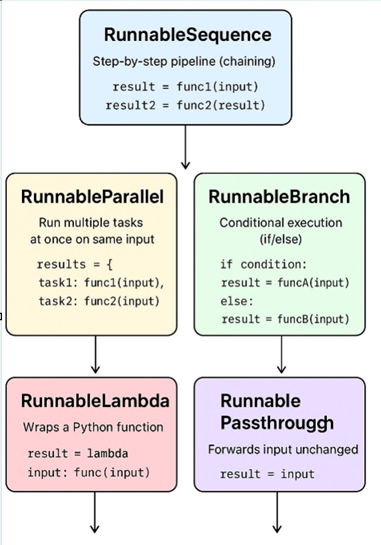

In [3]:
import os
from google.colab import userdata
from langchain_core.runnables import RunnablePassthrough, RunnableLambda
from langchain_core.output_parsers import StrOutputParser
from langchain_core.prompts import PromptTemplate
from langchain_google_genai import ChatGoogleGenerativeAI

# Retrieve the key from Colab Secrets
os.environ["GOOGLE_API_KEY"] = userdata.get('GOOGLE_API_KEY')

# Initialize the Model
chat = ChatGoogleGenerativeAI(
    model="gemini-2.5-flash-lite",
    max_retries=6,  # Automatically retry up to 6 times
    temperature=1.0
)

# 1. Define Destination Chains
math_chain = PromptTemplate.from_template("Solve this math problem: {input}") | chat | StrOutputParser()
history_chain = PromptTemplate.from_template("Explain this historical event: {input}") | chat | StrOutputParser()
default_chain = PromptTemplate.from_template("Answer this: {input}") | chat | StrOutputParser()

# 2. Router Logic
router_prompt = PromptTemplate.from_template(
    "Classify the input as 'math', 'history', or 'other'. Reply with only the word. \nInput: {input}"
)
router_chain = router_prompt | chat | StrOutputParser()

# 3. Decision Function
def route(info):
    topic = info["topic"].lower()
    if "math" in topic:
        return math_chain
    elif "history" in topic:
        return history_chain
    else:
        return default_chain

# 4. Construct the Full Chain
# RunnablePassthrough() passes the original user string into the 'input' key
full_chain = (
    {"topic": router_chain, "input": RunnablePassthrough()}
    | RunnableLambda(route)
)

# 5. Run it
result = full_chain.invoke("What is the derivative of x squared?")
print(result)



To find the derivative of $x^2$, we use the power rule. The power rule states that for a function of the form $f(x) = x^n$, its derivative is given by $f'(x) = nx^{n-1}$.

In this case, our function is $f(x) = x^2$.
Here, the exponent $n$ is 2.

Applying the power rule:
1. Multiply the coefficient of $x$ (which is 1) by the exponent $n$ (which is 2): $1 * 2 = 2$.
2. Subtract 1 from the exponent $n$: $2 - 1 = 1$.
3. The new function will have the new coefficient and the new exponent: $2x^1$.

Since $x^1$ is simply $x$, the derivative of $x^2$ is $2x$.

The final answer is $\boxed{2x}$.
